## Variational Zero-inflated Gaussian Processes in GPFlow

In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import gpflow as gpf
import numpy as np
gpf.config.set_default_float(np.float32)

gpf.config.set_default_jitter(tf.cast(1e-6, dtype=gpf.default_float()))
from onoffgpf import OnOffSVGP, OnOffLikelihood
from onoffgpf.PlotOnOff1D import PlotOnOff1D

from gpflow.ci_utils import ci_niter

import gpflow

import scipy.io as sio
import matplotlib.pyplot as plt

import tensorflow_probability as tfp

** Load simulated dataset **

In [2]:
matdata = sio.loadmat('data/toydata.mat')
Xtrain = matdata['x'].astype(gpf.default_float())
Ytrain = matdata['y'].astype(gpf.default_float())

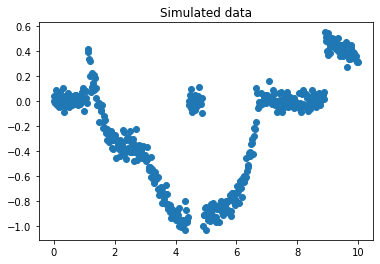

In [3]:
plt.scatter(Xtrain,Ytrain)
plt.title("Simulated data")
plt.show()

**Train specifications & variable initializations**

In [4]:
num_iterations = 8000
num_inducing   = 10

# initalize kernel parameters
kf = gpf.kernels.RBF(variance=1, lengthscales=2)
#kf.lengthscales = 2.
#kf.variance = 1.

kg = gpf.kernels.RBF(variance=5, lengthscales=2)
#kg.lengthscales = 2.
#kg.variance = 5.

# initialise equally spaced inducing point locations
Zf = np.delete(np.linspace(min(Xtrain),max(Xtrain),num_inducing,endpoint=False),0).transpose().reshape(-1,1)
Zg = np.delete(np.linspace(min(Xtrain),max(Xtrain),num_inducing,endpoint=False),0).transpose().reshape(-1,1)

** Model build and training **

In [5]:
# model definition
m = OnOffSVGP(Xtrain, Ytrain
              ,kernf=kf,kerng=kg
              ,likelihood = OnOffLikelihood()
              ,Zf = Zf,Zg = Zg
             )

# fix the model noise term
m.likelihood.variance.assign(0.01)
from gpflow import set_trainable
set_trainable(m.likelihood.variance, True)

minibatch_size = 100

N=len(Xtrain)

train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(Xtrain,),
                                                    tf.convert_to_tensor(Ytrain,)),)#.repeat().shuffle(N)

train_iter = iter(train_dataset)#batch(minibatch_size))


In [6]:
def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = train_dataset#iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(compile=True)
    optimizer = tf.optimizers.Adam(learning_rate=0.005)#gpflow.optimizers.Adam(learning_rate=0.01)

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

In [7]:
maxiter = ci_niter(200000)

logf = run_adam(m, maxiter)

In [8]:
logf[-1]

528.4405

In [65]:
#m.optimize(maxiter = num_iterations) #,method= tf.train.AdamOptimizer(learning_rate = 0.01)
m.compute_log_likelihood()

AttributeError: 'OnOffSVGP' object has no attribute 'compute_log_likelihood'

** Mode fit visualization **

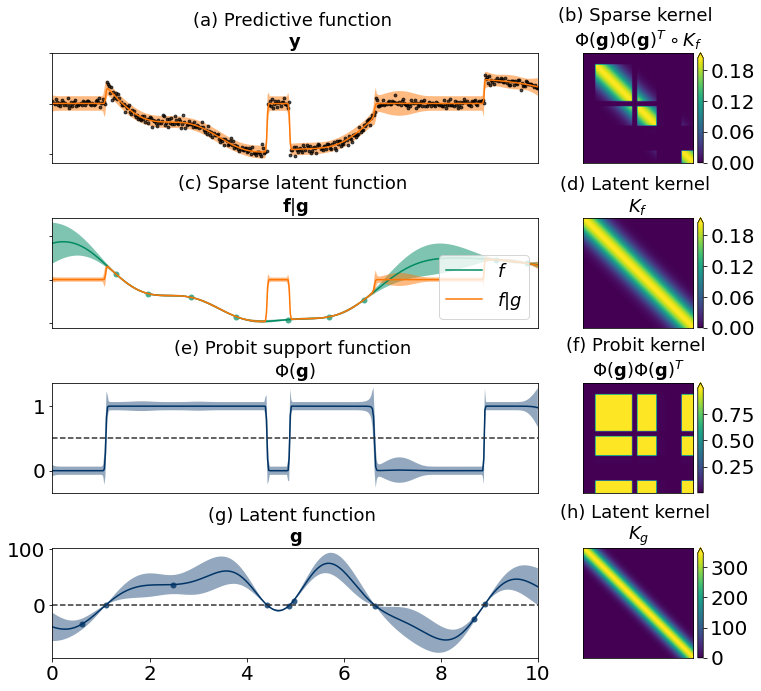

In [93]:
# model plot
PlotOnOff1D(m)

In [66]:
Xtrain.shape

(450, 1)

In [67]:
from gpflow.config import default_jitter

In [13]:
default_jitter()

<tf.Tensor: shape=(), dtype=float32, numpy=1e-06>

In [14]:
f.eye(m.num_inducing_f, dtype=float_type) * default_jitter()

NameError: name 'f' is not defined

In [ ]:
kf.K(Xtrain)

In [ ]:
default_float

In [ ]:
gpf.default_float()

In [ ]:
m.X.dtype

In [ ]:
m.Zf.numpy()

In [ ]:
m.likelihood.variance

In [ ]:
m.kernf.K(m.Xtrain)

In [ ]:
dir(m.kernf)

In [ ]:
import scipy
optimizer = tf.optimizers.Adam()
optimizer.minimize(
    m.training_loss_closure(),
    m.trainable_variables,
)

In [ ]:
m.training_loss_closure()

In [ ]:
m.trainable_variables

In [ ]:
m.training_loss()

In [38]:
m

name,class,transform,prior,trainable,shape,dtype,value
OnOffSVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float32,0.04110934
OnOffSVGP.Zf,Parameter,Identity,,True,"(9, 1)",float32,[[-1.424971...
OnOffSVGP.Zg,Parameter,Identity,,True,"(9, 1)",float32,[[-2.149004...
OnOffSVGP.u_fm,Parameter,Identity,,True,"(9, 1)",float32,[[-0.0846932...
OnOffSVGP.u_gm,Parameter,Identity,,True,"(9, 1)",float32,[[-1.0552356...
OnOffSVGP.u_fs_sqrt,Parameter,Softplus,,True,"(9, 1)",float32,[[0.57688844...
OnOffSVGP.u_gs_sqrt,Parameter,Softplus,,True,"(9, 1)",float32,[[1.9072903...


In [26]:
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(
    m.training_loss_closure(compile=True),
    m.trainable_variables,
    options=dict(maxiter=(80000),),tol=1e-16
)

      fun: -252.29525756835938
 hess_inv: <59x59 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.54452801e-01,  7.68044829e-01,  5.91257572e+00, -3.97183418e+00,
       -5.27718544e-01,  3.20123386e+00, -1.45729065e+00, -8.55290413e-01,
        2.04404044e+00,  6.10290337e+00, -5.41131592e+00, -1.17062588e+01,
        2.10207062e+01, -5.10620117e+00,  2.86854248e+01,  9.04017639e+00,
       -6.14822388e+00,  5.69590807e-01,  3.84891176e+00,  7.46709919e+00,
        1.86324997e+01, -1.41025639e+01,  5.99982738e+00, -2.20075798e+00,
        9.69505310e-03,  4.70506477e+00,  3.56710911e+00, -8.19399893e-01,
       -6.48524284e-01,  5.36472619e-01, -5.69515824e-02,  1.58759832e-01,
       -5.50393403e-01,  9.19881940e-01,  1.73107982e-01, -6.20592356e-01,
       -1.15292454e+00, -3.71976376e-01, -6.56942368e+00, -2.98317432e-01,
        6.52072906e-01, -2.70233154e-02, -3.91662121e-01, -4.64838982e-01,
       -3.35811496e-01, -2.19558835e-01, -2.26756036e-01, -8.89124513e-01,


In [31]:
m.likelihood

name,class,transform,prior,trainable,shape,dtype,value
OnOffLikelihood.variance,Parameter,Softplus + Shift,,True,(),float32,0.0407482


In [19]:
dir(m)

['ProbitExpectations',
 'X',
 'Xtrain',
 'Y',
 'Ytrain',
 'Zf',
 'Zg',
 '_TF_MODULE_IGNORED_PROPERTIES',
 '__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_checkpoint_dependencies',
 '_deferred_dependencies',
 '_delete_tracking',
 '_deserialization_dependencies',
 '_deserialize_from_proto',
 '_export_to_saved_model_graph',
 '_flatten',
 '_gather_saveables_for_checkpoint',
 '_get_legacy_saved_model_children',
 '_handle_deferred_dependencies',
 '_list_extra_dependencies_for_serialization',
 '_list_functions_for_serialization',
 '_lookup_dependency',
 '_m

In [22]:
m.likelihood

name,class,transform,prior,trainable,shape,dtype,value
OnOffLikelihood.variance,Parameter,Softplus + Shift,,False,(),float32,0.01


In [39]:
m.Zf

<Parameter: name=identity, dtype=float32, shape=[9, 1], fn="identity", numpy=
array([[-1.424971 ],
       [ 0.8191449],
       [ 2.4437728],
       [ 3.756588 ],
       [ 5.4873586],
       [ 6.7399635],
       [ 8.854808 ],
       [ 9.710754 ],
       [12.028399 ]], dtype=float32)>

In [44]:
m.Zg

<Parameter: name=identity, dtype=float32, shape=[9, 1], fn="identity", numpy=
array([[-2.149004  ],
       [ 0.88961995],
       [ 2.6740112 ],
       [ 3.8661952 ],
       [ 4.9942446 ],
       [ 6.1200147 ],
       [ 7.7307625 ],
       [ 9.103663  ],
       [14.580972  ]], dtype=float32)>

In [46]:
Zf

array([[1.],
       [2.],
       [3.],
       [4.],
       [5.],
       [6.],
       [7.],
       [8.],
       [9.]], dtype=float32)

In [51]:
dir(m.kerng)

['K',
 'K_diag',
 'K_r2',
 '_TF_MODULE_IGNORED_PROPERTIES',
 '__abstractmethods__',
 '__add__',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_active_dims',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_checkpoint_dependencies',
 '_deferred_dependencies',
 '_delete_tracking',
 '_deserialization_dependencies',
 '_deserialize_from_proto',
 '_export_to_saved_model_graph',
 '_flatten',
 '_gather_saveables_for_checkpoint',
 '_get_legacy_saved_model_children',
 '_handle_deferred_dependencies',
 '_list_extra_dependencies_for_serialization',
 '_list_functions_for_serialization',
 '_lookup_dependen

In [54]:
m.kerng.variance

5.0

In [58]:
m.kernf.lengthscales

2.0

In [59]:
m.kerng

In [60]:

from gpflow.utilities import print_summary

In [70]:
print_summary(kg)

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float32 │       5 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float32 │       2 │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛


In [87]:
m.log_posterior_density

<bound method BayesianModel.log_posterior_density of <onoffgpf.OnOffSVGP.OnOffSVGP object at 0x7f7d8c932410>>

In [1]:
plt.plot(range(len(logf)), logf)
plt.ylim(-200,600)

NameError: name 'plt' is not defined